In [112]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import time, sys

### Постановка и сеточные параметры

Рассмотрим задачу об эволюции ступеньки. Численное решается уравнение переноса с коэффициентом переноса $c$.

In [113]:
nx = 81  # количество узлов по пространству
dx = 2 / (nx-1) # шаг по пространству
nt = 25    # количество узлов по времени
dt = .025  # шаг по времени
T = dt * (nt-1)
c = 1      # скорость распространения возмущения (коэффициент переноса)
x_mesh = np.linspace(0, 2, nx) #сетка по пространству
r = c * dt / dx # число Куранта
print('r = ', r)
print('T = ', T)

r =  1.0
T =  0.6000000000000001


#### Начальные условия

Зададим $u(x, 0) = 2$ при $x \in [0.5, 1]$ и $u(x, 0) = 1$ иначе во всей расчетной области. Такая функция называется "ступенька". 

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]


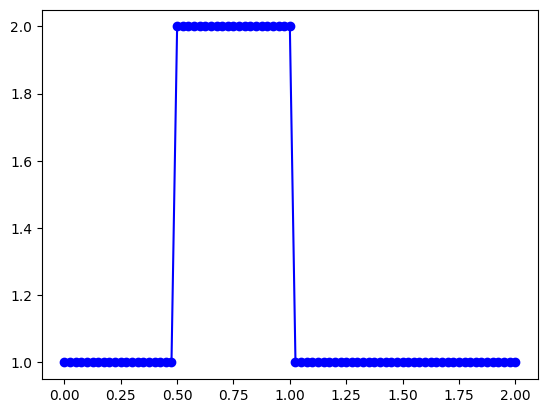

In [114]:
u_init = np.ones(nx)      
u_init[int(.5 / dx):int(1 / dx + 1)] = 2  
plt.plot(x_mesh, u_init, '-bo')
print(u_init)

#### Точное решение

К моменту времени T ступенька просто сдвинется вправо

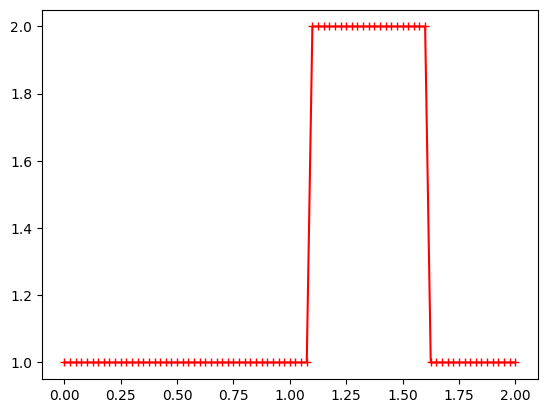

In [115]:
u_exact = np.ones(nx)      
u_exact[int((.5+c*T) / dx):int((1+c*T) / dx + 1)] = 2  
plt.plot(x_mesh, u_exact, '-r+')

### Численное решение

#### Часть 1. Явный левый уголок
Сначала примените схему Явный левый уголок (Upwind scheme). Провести расчеты для $nx = 41; 81; 121$. Построить графики решения

In [116]:
def left_corner_scheme(u_init, nx, nt, dt, c):
    dx = 2 / (nx - 1)
    r = c * dt / dx
    u = u_init.copy()
    un = np.ones(nx)

    print(f'nx = {nx}, r = {r}')
    
    for n in range(1, nt):
        un = u.copy()
        for i in range(1, nx):
            u[i] = un[i] - r * (un[i] - un[i-1])

    return u

# Общие параметры
nt = 25
dt = 0.025
c = 1
T = dt * (nt - 1)

nx = 41, r = 0.5
nx = 61, r = 0.75
nx = 81, r = 1.0
nx = 121, r = 1.5


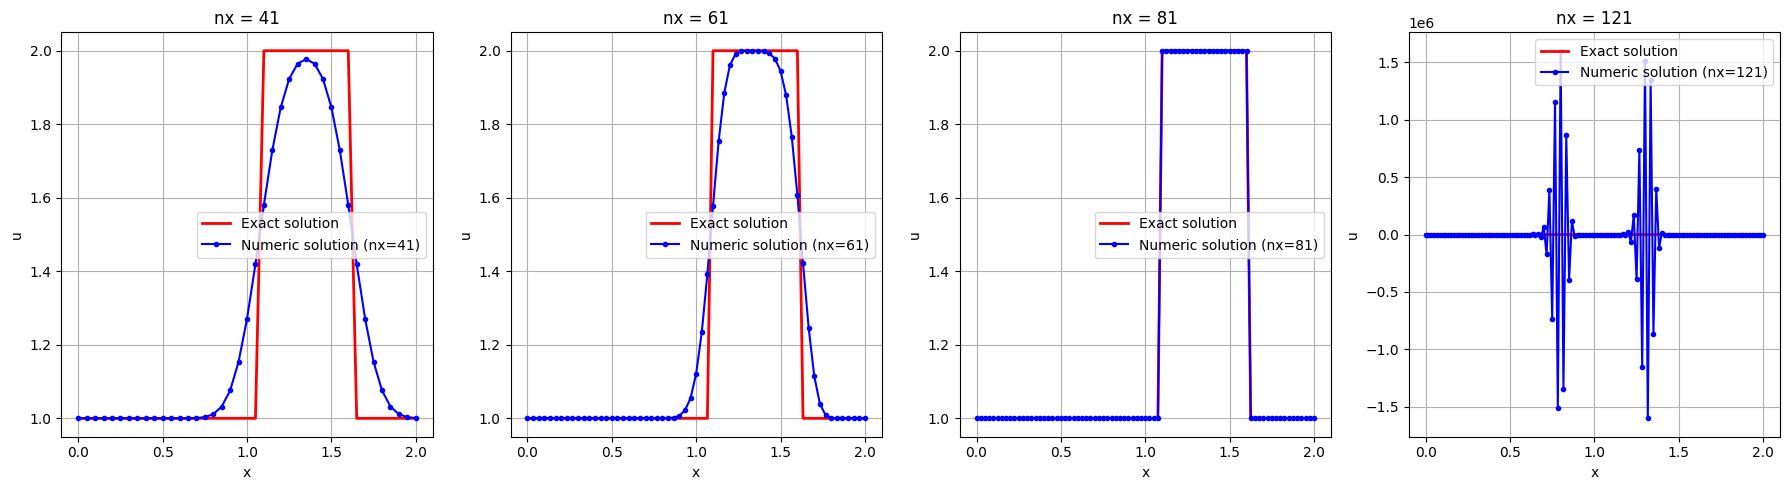

In [117]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# Перебираем разные значения nx
for idx, nx in enumerate([41, 61, 81, 121]):
    dx = 2 / (nx - 1)
    x_mesh = np.linspace(0, 2, nx)
    
    # Начальное условие
    u_init = np.ones(nx)
    u_init[int(0.5 / dx):int(1 / dx + 1)] = 2
    
    # Точное решение
    u_exact = np.ones(nx)
    u_exact[int((0.5 + c * T) / dx):int((1 + c * T) / dx + 1)] = 2
    
    # Численное решение
    u_numeric = left_corner_scheme(u_init, nx, nt, dt, c)
    
    # Построение на текущем подграфике
    ax = axes[idx]
    ax.plot(x_mesh, u_exact, 'r-', label='Exact solution', linewidth=2)
    ax.plot(x_mesh, u_numeric, 'bo-', markersize=3, label=f'Numeric solution (nx={nx})')
    ax.set_title(f'nx = {nx}')
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

0. Какой у схемы порядок аппроксимации?
1. Удалось ли получить решение? Почему?
2. Сколько граничных условий и где нужно поставить в этой задаче?
3. Почему в задаче явно нигде не инициализируются граничные условия?
4. Почему в цикле по пространству индексация с 1?
5. Можно ли решить задачу схемой Явный правый уголок?
6. Почему при решении на 41 узле решение размывается, а на 81 узле нет?
7. Объясните причину размытия решения.

Для ответа на шестой вопрос может быть полезна книга [1], c.71

1. Зализняк В.Е. Основы вычислительной физики. Часть 1. Введение в конечно-разностные методы

### Часть 1. Ответ:
#### 0) Какой у схемы порядок аппроксимации:

Уравнение переноса: 
$$
\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0
$$

Аппроксимация уравнения переноса схемой явного левого уголка:
$$
\frac{u_i^{n+1} - u_i^n}{\tau} + c \cdot \frac{u_i^n - u_{i-1}^n}{h} = 0
$$
или, решённая относительно $ u_i^{n+1} $:
$$
u_i^{n+1} = u_i^n - r \left( u_i^n - u_{i-1}^n \right), \quad \text{где } r = \frac{c \tau}{h}
$$

Невязка схемы при подстановки точного решения в разностную схему получается следующего вида:
$$
R_i^n = \frac{\tau}{2} \cdot u_{tt} - \frac{c h}{2} \cdot u_{xx} + \mathcal{O}(\tau^2 + h^2)
$$
Откуда видно, что схема имеет **ПЕРВЫЙ** порядок аппроксимации по $\tau$ и по h (что было показано на семинаре)

#### 1) Удалось ли получить решение? Почему?
Для ответа на этот вопрос необходимо воспользоваться спектральным признаком устойчивости для схемы явного левого уголка:

Предположим решение в виде:
$$
u_i^n = \lambda(\varphi)^n \cdot e^{j i \varphi},
$$
где $j$ — мнимая единица

Подставляя это выражение в схему, получаем формулу для собственных чисел переходного оператора:
$$
\lambda(\varphi) = 1 - r + r \cos(\varphi) - j * r \sin(\varphi),
$$
где $r = \dfrac{c \tau}{h}$

Спектральный признак устойчивости требует:
$$
|\lambda(\varphi)| \leq 1 \quad \text{при всех } \varphi
$$

Подставляя выражение для $\lambda(\varphi)$, получаем:
$$
|\lambda(\varphi)|^2 = \left(1 - r + r \cos(\varphi)\right)^2 + \left(r \sin(\varphi)\right)^2 \leq 1
$$
$$
r^2 - r \leq 1
$$

Выводим условие устойчивости:
$$
r \leq 1 \quad \text{при } c > 0
$$

При изменение параметров nx можно заметить как меняется число Куранта: $$nx = 41 \implies r = 0.5$$ $$nx = 81 \implies r = 1.0$$ $$nx = 121 \implies r = 1.5$$

Тогда легко понять, что схема будет являться **УСТОЙЧИВОЙ** при $nx \leq 81$ (и соответственно нам возможно удастся получить решение)
Из самого графика видно, что при nx = 121 нам не удалось получить решение, при nx = 81 нам удалось получить точное решение, а при nx = 41 решение было размазано, но видно, что близко к реальному решению

#### 2) Сколько граничных условий и где нужно поставить в этой задаче:
В данном уравнение гиперболического типа мы имеем только одно собственное значение $\lambda = c > 0$, соответственно нам необходимо только **ОДНО ЛЕВОЕ** граничное условие, чтобы вдоль характеристик у нас переносились решения с этого самого левого граничного условия и с начальных условий.  Характеристика идёт вправо, и значения справа определяются значениями слева

#### 3) Почему в задаче явно нигде не инициализируются граничные условия: + 4) Почему в цикле по пространству индексация начинается с 1:
Потому что левая границы сохраняется из начальной инициализации u_init: u[0] = 1. И это условие верно всегда, поскольку c > 0, соответственно u[0] = 1 просто не изменяется с течением времени и её перерасчёт не нужен (отсюда range(1, nx)). По факту же мы продолжаем использовать это значение и дальше при вычислениях на первом шаге i = 1. Неизменяемость u[0] = 1 неявно даёт нам граничное условие

#### 5) Можно ли решить задачу схемой явный правый уголок:
Рассмотрим схему явного правого уголка и спектральный признак для неё:
$$
u_i^{n+1} = u_i^n - r \left( u_{i+1}^n - u_i^n \right), \quad \text{где } r = \frac{c \tau}{h}
$$

Спектральный признак устойчивости:
$$
u_j^n = \lambda(\varphi)^n \cdot e^{j i \varphi}
$$

Подставляя в правую схему, получаем:
$$
\lambda(\varphi) = 1 - r (e^{i\varphi} - 1) = 1 - r (\cos\varphi + i\sin\varphi - 1)
$$

Разложим на действительную и мнимую часть, и найдём модуль:
$$
|\lambda(\varphi)|^2 = \left(1 - r(\cos\varphi - 1)\right)^2 + \left(r \sin\varphi\right)^2 \leq 1
$$
$$
r^2 + r \leq 1
$$

Из этого видно, что при $r > 0$ модуль $\lambda(\varphi)$ может превышать $1$, то есть:
$$
|\lambda(\varphi)| > 1 \quad \Rightarrow \quad \text{схема неустойчива при } c > 0
$$
Соответственно применять её для случая c > 0 **НЕЛЬЗЯ**

#### 6) + 7) Размытие решения при nx = 41:

Рассмотрим дисперсию и диссипацию для нашего уравнения переноса:
$$
\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0
$$

Рассмотрим волновое решение, которое используется для вывода дисперсионного соотношения и анализа численных эффектов:
$$
u(x, t) = e^{i(kx - \omega t)}
$$

При подстановке этого решения в наше уравнение переноса легко получить дисперсионное соотношение:
$$
\omega = ck
$$
Откуда легко найти фазовый и групповые скорости $c_f = c_g = c$ (нет дисперсии). К тому же мы видим, что дисперсионное соотношение не содержит мнимной части и соответственно в решение не должно быть диссипации со временем.

Теперь рассмотрим нашу разностную схему и подставим туда решение в виде:
$$
u_i^n = e^{i(\omega \tau n - k h i)} = e^{i(\omega t_n - k x_i)},
$$

И получим следующее дисперсионное соотношение:
$$
e^{i\omega \tau} = 1 - r \left(1 - e^{ik h} \right)
$$

Введём $\omega = {\omega}_0 + i \gamma$. Приравняем вещественные и мнимые части и получим уравнение на коэффициет затухания $d = \gamma \tau$. Рассмотрим его в случае минимальной длины волны, представленной на сетка ($kh = \pi / 2$). Гармоники такой длины волны сильнее всего подвержены дисперсии

Система уравнений:
$$
e^{-d} cos({\omega}_0 \tau) = 1 - r + r cos(kh)
$$
$$
e^{-d} sin({\omega}_0 \tau) = r sin(kh)
$$

Откуда получаем, что:
$$
d = -\frac{1}{2} ln[(1 - r)^2 + r^2]
$$
и групповая скорость равна:
$$
c_g = c \frac{r}{r^2 + (1 - r)^2}
$$

Ниже приведены их графики, из которых видно, что при r = 1 (nx = 81) **НЕТ** ни диссипации, ни дисперсии численного решения. Однако при r = 0.5 (nx = 41) коэффициент затухания и соответственно диссипация решения будут **МАКСИМАЛЬНЫ**, однако дисперссии всё так же не будет. Однако для случая nx = 121 $c_g = 0.6c$ и будет наблюдаться дисперсия численного решения (которого нет из-за неустойчивости метода при r > 1)


C:\Users\maslo\AppData\Local\Temp\ipykernel_19056\677567971.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\maslo\AppData\Local\Temp\ipykernel_19056\677567971.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


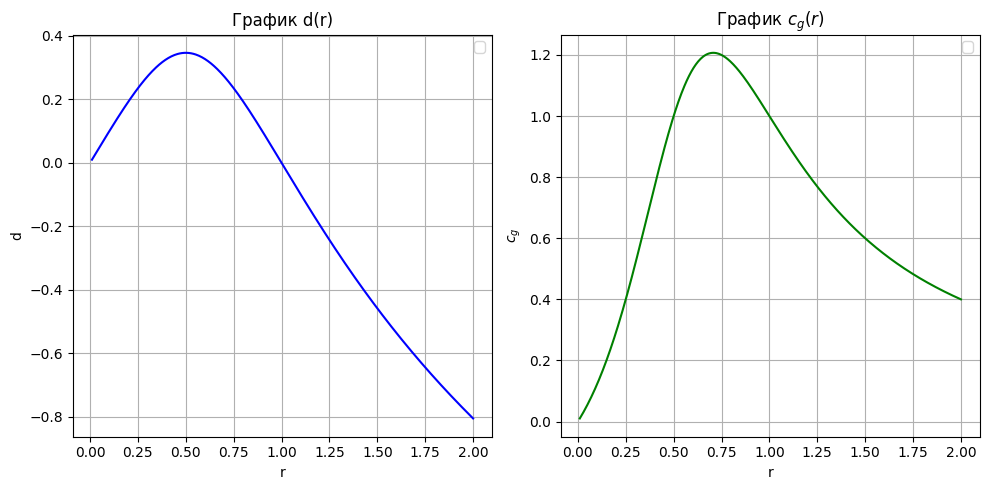

In [118]:
r = np.linspace(0.01, 2, 500)
d = -0.5 * np.log((1 - r)**2 + r**2)
c = 1
cg = c * r / (r**2 + (1 - r)**2)
plt.figure(figsize=(10, 5))

# График функции d(r)
plt.subplot(1, 2, 1)
plt.plot(r, d, color='blue')
plt.xlabel('r')
plt.ylabel('d')
plt.title('График d(r)')
plt.grid(True)
plt.legend()

# График функции c_g(r)
plt.subplot(1, 2, 2)
plt.plot(r, cg, color='green')
plt.xlabel('r')
plt.ylabel(r'$c_g$')
plt.title('График $c_g(r)$')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

#### Часть 2. Схема МакКормака 

Теперь примените схему МакКормака (MacCormack method). Провести расчеты для $nx = 41; 81; 121$. Построить графики решения

In [119]:
def mccormack_scheme(u_init, nx, nt, dt, c):
    dx = 2 / (nx - 1)
    r = c * dt / dx

    print(f'nx = {nx}, r = {r}')
    
    u = u_init.copy()
    up = np.ones(nx)
    
    for n in range(1, nt):
        # Шаг предиктора (форвардные разности)
        up[:-1] = u[:-1] - r * (u[1:] - u[:-1])
        
        # Шаг корректора (обратные разности)
        u[1:] = 0.5 * (u[1:] + up[1:] - r * (up[1:] - up[:-1]))
    
    return u

# Общие параметры
nt = 25
dt = 0.025
c = 1
T = dt * (nt - 1)

nx = 41, r = 0.5
nx = 58, r = 0.7125000000000001
nx = 81, r = 1.0
nx = 121, r = 1.5


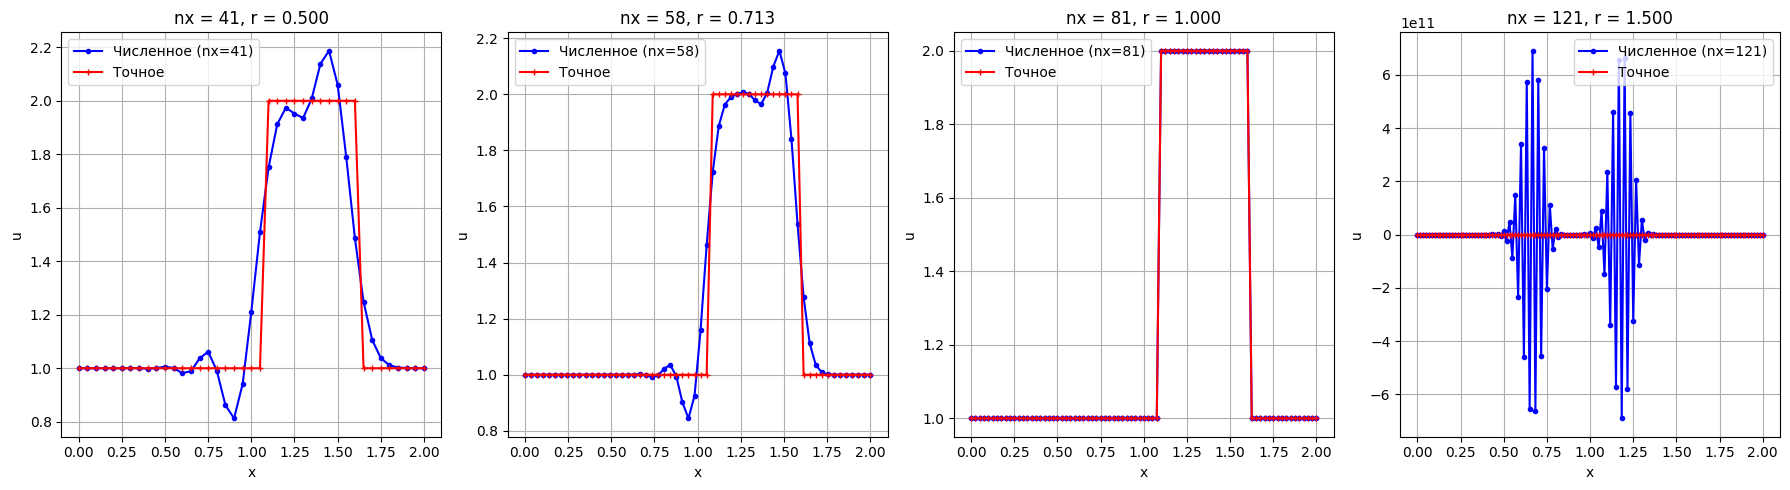

In [131]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# Перебираем разные значения nx
for idx, nx in enumerate([41, 58, 81, 121]):
    dx = 2 / (nx - 1)
    x_mesh = np.linspace(0, 2, nx)
    r = c * dt / dx
    
    # Начальные условия
    u_init = np.ones(nx)
    u_init[int(0.5 / dx):int(1 / dx + 1)] = 2
    
    # Точное решение
    u_exact = np.ones(nx)
    u_exact[int((0.5 + c * T) / dx):int((1 + c * T) / dx + 1)] = 2
    
    # Численное решение по схеме МакКормака
    u_numeric = mccormack_scheme(u_init, nx, nt, dt, c)
    
    # Построение графика
    ax = axes[idx]
    ax.plot(x_mesh, u_numeric, 'bo-', markersize=3, label=f'Численное (nx={nx})')
    ax.plot(x_mesh, u_exact, 'r+-', markersize=4, label='Точное')
    ax.set_title(f'nx = {nx}, r = {r:.3f}')
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

0. Какой у схемы порядок аппроксимации?
1. Удалось ли получить решение? Почему?
2. Почему при решении на 41 узле решение осциллирует, а на 81 узле нет?
3. Объясните причину осцилляций.
4. Совпадает ли схема со схемой Лакса-Вендроффа для данной задачи (Lax–Wendroff method)?

### Ответ на 2 часть:

#### 0) Какой у схемы порядок:
Схема состоит из двух частей:
1) Предиктор:

$$
u_i^p = u_i^n - c \frac{\tau}{h} (u_{i+1}^n - u_i^n)
$$

2) Корректор:

$$
u_i^{n+1} = u_i^n + \frac{u_i^p + u_i^n}{2} - c \frac{\tau}{2h} (u_i^p - u_{i-1}^p)
$$

Теперь подставим значение предиктора в корректор и рассмотрим полученное выражение:
$$
u_i^{n+1} = u_i^n - \frac{r}{2} (u_{i+1}^n - u_{i-1}^n) + \frac{r^2}{2} (u_{i+1}^n - 2u_i^n + u_{i-1}^n)
$$

Подставим в это уравнение точное решение и получим, что невязка:
$$
R_i^n = O(\tau^2, h^2)
$$

То есть метод имеет **ВТОРОЙ** порядок по времени и пространству

#### 1) Удалось ли получить решение:
Точное решение удалось получить только в случае r = 1, проверим схему на устойчивость по спектральному признаку:
Предположим решение в виде:
$$
u_i^n = \lambda(\varphi)^n \cdot e^{j i \varphi},
$$
где $j$ — мнимая единица

Спектральный признак устойчивости требует:
$$
|\lambda(\varphi)| \leq 1 \quad \text{при всех } \varphi
$$

Тогда получаем условие устойчивости метода:
$$
r \leq 1 \quad
$$

Получаем аналогично первой части, что метод неустойчив при nx = 121

#### 2) + 3) Почему решение на одном узле осциллирует, а на 81 - нет:

Проведем исследование на дисперсию и диссипацию аналогично схеме явного левого уголка
Теперь рассмотрим нашу разностную схему и подставим туда решение в виде:
$$
u_i^n = e^{i(\omega \tau n - k h i)} = e^{i(\omega t_n - k x_i)},
$$

И получим следующее дисперсионное соотношение:
$$
e^{i\omega \tau} = 1 + i r sin(kh) + r^2 (cos(kh) - 1)
$$

Введём $\omega = {\omega}_0 + i \gamma$. Приравняем вещественные и мнимые части и получим уравнение на коэффициет затухания $d = \gamma \tau$. Рассмотрим его в случае минимальной длины волны, представленной на сетка ($kh = \pi / 2$). Гармоники такой длины волны сильнее всего подвержены дисперсии

Система уравнений:
$$
e^{-d} cos({\omega}_0 \tau) = 1 + r^2 (cos(kh) - 1)
$$
$$
e^{-d} sin({\omega}_0 \tau) = r sin(kh)
$$

Откуда получаем, что:
$$
d = -\frac{1}{2} ln[r^2 sin^2(kh) + (1 - r^2 + r^2 cos(kh))^2] = -\frac{1}{2} ln[r^2 + (1 - r^2)^2]
$$
и групповая скорость равна:
$$
c_g = c \frac{r^2}{1 - r^2 + r^4}
$$

Ниже приведены графики для параметра диссипации и относительной групповой скорости. Из которых видно, что параметр диссипации мал (при r = 1 равен нулю), а относительная групповая скорость < 1 при r < 1. А при r = 1 нет дисперсии. Поэтому при nx = 81  (r = 1) получаем точное решение, а при nx = 41 (r = 0.5) сильно влияение дисперсии, однако влияние диссипации мало.

#### 4) Совпадает ли схема со схемой Лакса-Вендроффа для данной задачи:

Для схемы МакКормака в случае уравнения переноса мы получили:
$$
u_i^{n+1} = u_i^n - \frac{r}{2} (u_{i+1}^n - u_{i-1}^n) + \frac{r^2}{2} (u_{i+1}^n - 2u_i^n + u_{i-1}^n)
$$

Что в точности соответствует схеме Лакса-Вендроффа. Поэтому **ДА**, соответствует. Вообще говоря, если обратиться к литературе, то указано, что в линейном случае (f = c*u) схема МакКормака соответствует схеме Лакса-Вендроффа

C:\Users\maslo\AppData\Local\Temp\ipykernel_19056\1978657810.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\maslo\AppData\Local\Temp\ipykernel_19056\1978657810.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


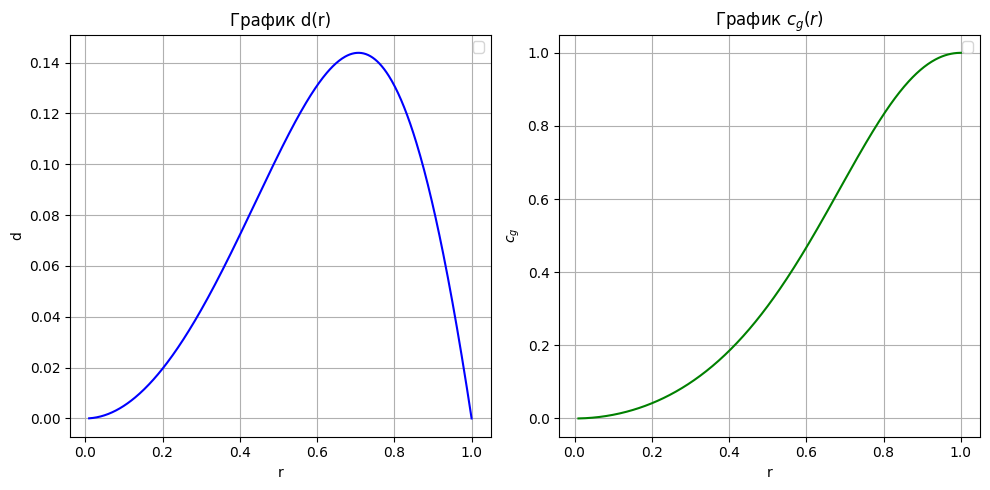

In [121]:
r = np.linspace(0.01, 1, 500)
d = -0.5 * np.log(r ** 2 + (1 - r ** 2) ** 2)
c = 1
cg = c * (r ** 2) / (1 - r ** 2 + r ** 4)
plt.figure(figsize=(10, 5))

# График функции d(r)
plt.subplot(1, 2, 1)
plt.plot(r, d, color='blue')
plt.xlabel('r')
plt.ylabel('d')
plt.title('График d(r)')
plt.grid(True)
plt.legend()

# График функции c_g(r)
plt.subplot(1, 2, 2)
plt.plot(r, cg, color='green')
plt.xlabel('r')
plt.ylabel(r'$c_g$')
plt.title('График $c_g(r)$')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

#### Часть 3. Монотонная схема высокого порядка

1. Можно ли построить линейную монотонную по Годунову схему с порядком выше первого? Почему?
2. Постройте монотонную схему порядка выше первого и примените к решению задачи из предыдущих частей.

In [128]:
def fedorenko_scheme(u_init, nx, nt, dt, c, lambda_param=0.5):
    dx = 2 / (nx - 1)
    r = c * dt / dx

    print(f'nx = {nx}, r = {r}')
    
    u = u_init.copy()
    u_new = np.ones(nx)
    
    for n in range(1, nt):
        u_prev = u.copy()
        
        for i in range(1, nx-1):
            # Вычисляем разности
            du_first = u_prev[i] - u_prev[i-1]
            du_second = u_prev[i-1] - 2*u_prev[i] + u_prev[i+1]
            
            # Анализатор гладкости
            gamma = 1 if abs(du_second) < lambda_param * abs(du_first) else 0
            
            # Гибридная схема
            if gamma == 1:
                # Схема второго порядка
                u_new[i] = u_prev[i] - r*(u_prev[i] - u_prev[i-1]) - \
                          (r*(1 - r)/2) * (u_prev[i-1] - 2*u_prev[i] + u_prev[i+1])
            else:
                # Схема первого порядка
                u_new[i] = u_prev[i] - r*(u_prev[i] - u_prev[i-1])
        
        # Граничные условия
        u_new[0] = 1
        u_new[-1] = 1
        
        u = u_new.copy()
    
    return u

# Общие параметры
nt = 25
dt = 0.025
c = 1
T = dt * (nt - 1)
lambda_param = 0.1

nx = 41, r = 0.5
nx = 81, r = 1.0
nx = 121, r = 1.5


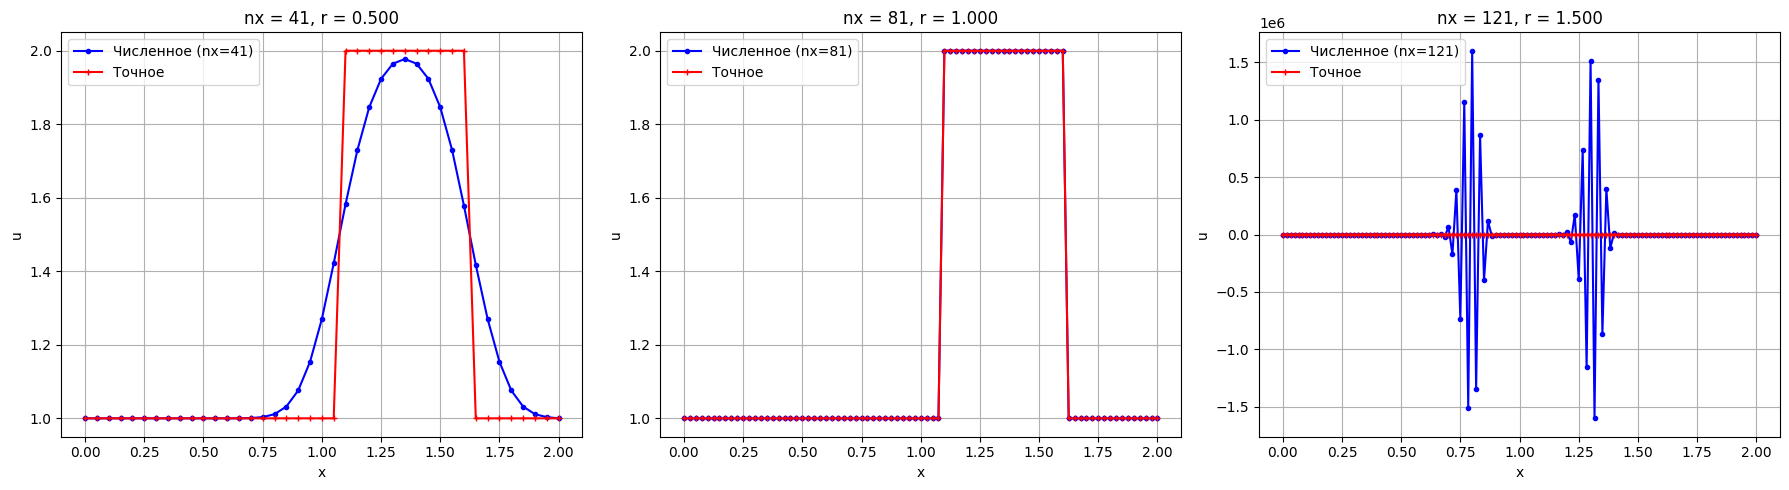

In [129]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Перебираем разные значения nx
for idx, nx in enumerate([41, 81, 121]):
    dx = 2 / (nx - 1)
    x_mesh = np.linspace(0, 2, nx)
    r = c * dt / dx
    
    # Начальные условия
    u_init = np.ones(nx)
    u_init[int(0.5 / dx):int(1 / dx + 1)] = 2
    
    # Точное решение
    u_exact = np.ones(nx)
    u_exact[int((0.5 + c * T) / dx):int((1 + c * T) / dx + 1)] = 2
    
    # Численное решение по схеме Федоренко
    u_numeric = fedorenko_scheme(u_init, nx, nt, dt, c, lambda_param)
    
    # Построение графика
    ax = axes[idx]
    ax.plot(x_mesh, u_numeric, 'bo-', markersize=3, label=f'Численное (nx={nx})')
    ax.plot(x_mesh, u_exact, 'r+-', markersize=4, label='Точное')
    ax.set_title(f'nx = {nx}, r = {r:.3f}')
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

### Ответ на 3 часть:

#### 1) Можно ли построить линейную монотонную по Годунову схему с порядком выше первого:

По теореме Годунова линейные монотонные схемы имеют порядок не выше первого. Значит построение линейной монотонной по Годунову схемы с порядком выше первого - **НЕВОЗМОЖНО**

#### 2) Постройте монотонную схему порядка выше первого и примените к решению задачи из предыщих частей:

Воспользуемся гибридной схемой (метод Р.П. Федоренко):

Простейшая разностная аппроксимация ("левый уголок")
$$
L_\tau u = \frac{u_{m}^{n+1} - u_{m}^{n}}{\tau} + c \cdot \frac{u_{m}^{n} - u_{m-1}^{n}}{h} = 0
$$
Эта схема имеет первый порядок аппроксимации по $\tau$ и $h$.

Разложим сеточную функцию до второго порядка:
$$
L_\tau u = \left( \frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} \right) + \frac{\tau}{2}  \frac{\partial^2 u}{\partial x^2} - \frac{ch}{2} \frac{\partial^2 u}{\partial x^2} + O(\tau^2 + h^2)
$$

Поскольку для уравнения переноса верно:
$$
\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}
$$

Подставим это в разложение сеточной функции, вычтем члены второго порядка и получим схему второго порядка:
$$
\frac{u_{m}^{n+1} - u_{m}^{n}}{\tau} + c \cdot \frac{u_{m}^{n} - u_{m-1}^{n}}{h} + \frac{1}{2 \tau} \left( \frac{c\tau}{h} - \frac{c^2\tau^2}{h^2} \right) \left( u_{m-1}^{n} - 2u_{m}^{n} + u_{m+1}^{n} \right) = 0
$$

Введем разностный анализатор гладкости численного решеия, сравнивая конечные разности первого и второго рода:
$$
\gamma_{m}^{n} = 
\begin{cases}
1, & \text{если } \left| u_{m-1}^{n} - 2u_{m}^{n} + u_{m+1}^{n} \right| < \lambda \left| u_{m}^{n} - u_{m-1}^{n} \right| \\
0, & \text{иначе}
\end{cases}
$$

Тем самым мы сохраним гладкость и уберем осцилляции решения. Добьемся монотонности за счет малого параметра $\lambda$

Метод сохраянет дисперсию


## В КЛАССЕ

In [124]:
def laks(u_init, nx, nt, dt, c):
    dx = 2 / (nx - 1)
    r = c * dt / dx
    u = u_init.copy()
    un = np.ones(nx)

    print(f'nx = {nx}, r = {r}')
    
    for n in range(1, nt):
        un = u.copy()
        for i in range(1, nx - 1):
            u[i] = 0.5 * (un[i + 1] + un[i - 1] - r * (un[i + 1] - un[i - 1]))
            #u[i] = un[i] - r * (un[i] - un[i-1])

    return u

# Общие параметры
nt = 25
dt = 0.025
c = 1
T = dt * (nt - 1)

nx = 41, r = 0.5
nx = 61, r = 0.75
nx = 81, r = 1.0
nx = 121, r = 1.5


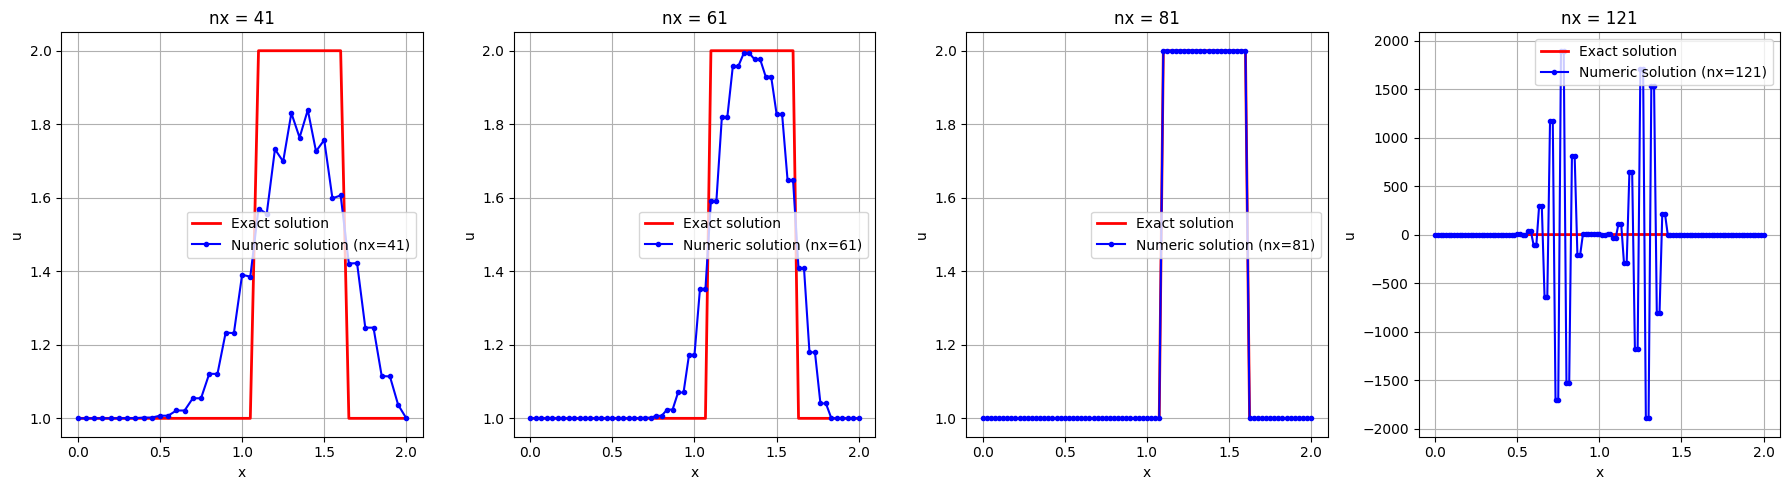

In [125]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# Перебираем разные значения nx
for idx, nx in enumerate([41, 61, 81, 121]):
    dx = 2 / (nx - 1)
    x_mesh = np.linspace(0, 2, nx)
    
    # Начальное условие
    u_init = np.ones(nx)
    u_init[int(0.5 / dx):int(1 / dx + 1)] = 2
    
    # Точное решение
    u_exact = np.ones(nx)
    u_exact[int((0.5 + c * T) / dx):int((1 + c * T) / dx + 1)] = 2
    
    # Численное решение
    u_numeric = laks(u_init, nx, nt, dt, c)
    
    # Построение на текущем подграфике
    ax = axes[idx]
    ax.plot(x_mesh, u_exact, 'r-', label='Exact solution', linewidth=2)
    ax.plot(x_mesh, u_numeric, 'bo-', markersize=3, label=f'Numeric solution (nx={nx})')
    ax.set_title(f'nx = {nx}')
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [126]:
def left_corner_scheme(u_init, nx, nt, dt, c):
    dx = 2 / (nx - 1)
    r = c * dt / dx
    u = u_init.copy()
    un = np.ones(nx)

    print(f'nx = {nx}, r = {r}')
    
    for n in range(1, nt):
        un = u.copy()
        for i in range(1, nx):
            u[i] = un[i] - r * (un[i] - un[i-1])

    return u

# Общие параметры
nt = 50
dt = 0.025
c = 1
T = dt * (nt - 1)

nx = 41, r = 0.5
nx = 61, r = 0.75
nx = 81, r = 1.0
nx = 121, r = 1.5


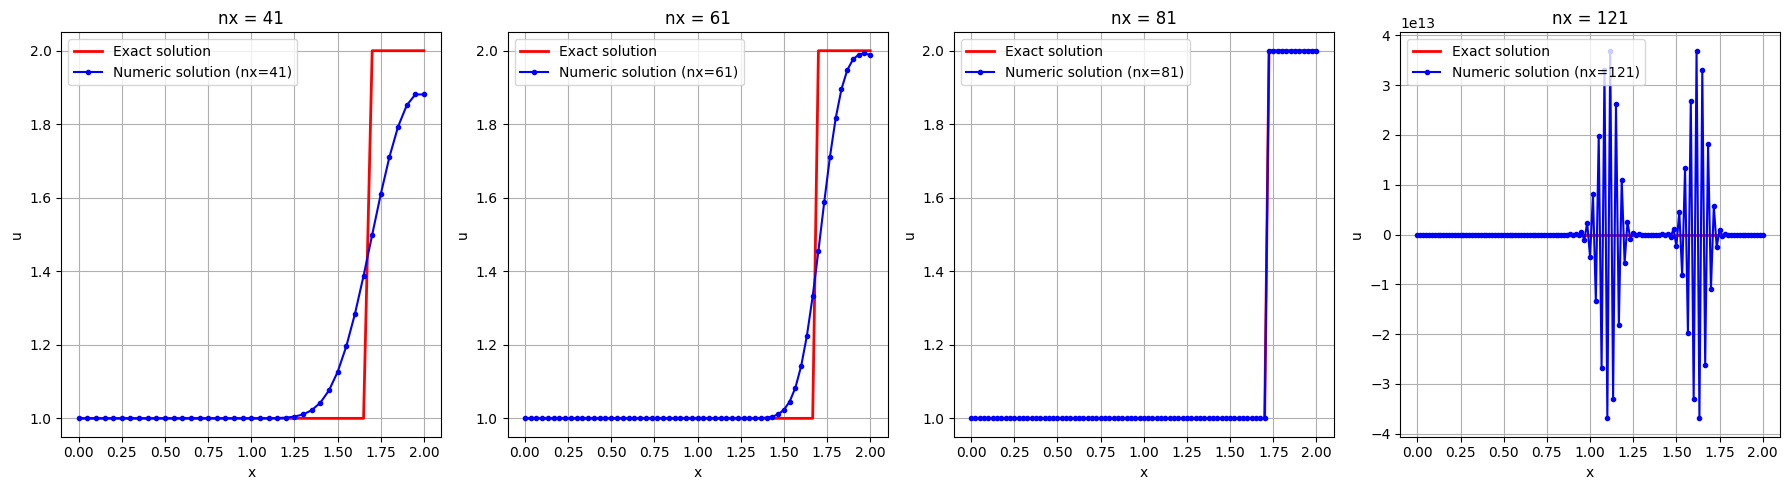

In [127]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# Перебираем разные значения nx
for idx, nx in enumerate([41, 61, 81, 121]):
    dx = 2 / (nx - 1)
    x_mesh = np.linspace(0, 2, nx)
    
    # Начальное условие
    u_init = np.ones(nx)
    u_init[int(0.5 / dx):int(1 / dx + 1)] = 2
    
    # Точное решение
    u_exact = np.ones(nx)
    u_exact[int((0.5 + c * T) / dx):int((1 + c * T) / dx + 1)] = 2
    
    # Численное решение
    u_numeric = left_corner_scheme(u_init, nx, nt, dt, c)
    
    # Построение на текущем подграфике
    ax = axes[idx]
    ax.plot(x_mesh, u_exact, 'r-', label='Exact solution', linewidth=2)
    ax.plot(x_mesh, u_numeric, 'bo-', markersize=3, label=f'Numeric solution (nx={nx})')
    ax.set_title(f'nx = {nx}')
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()